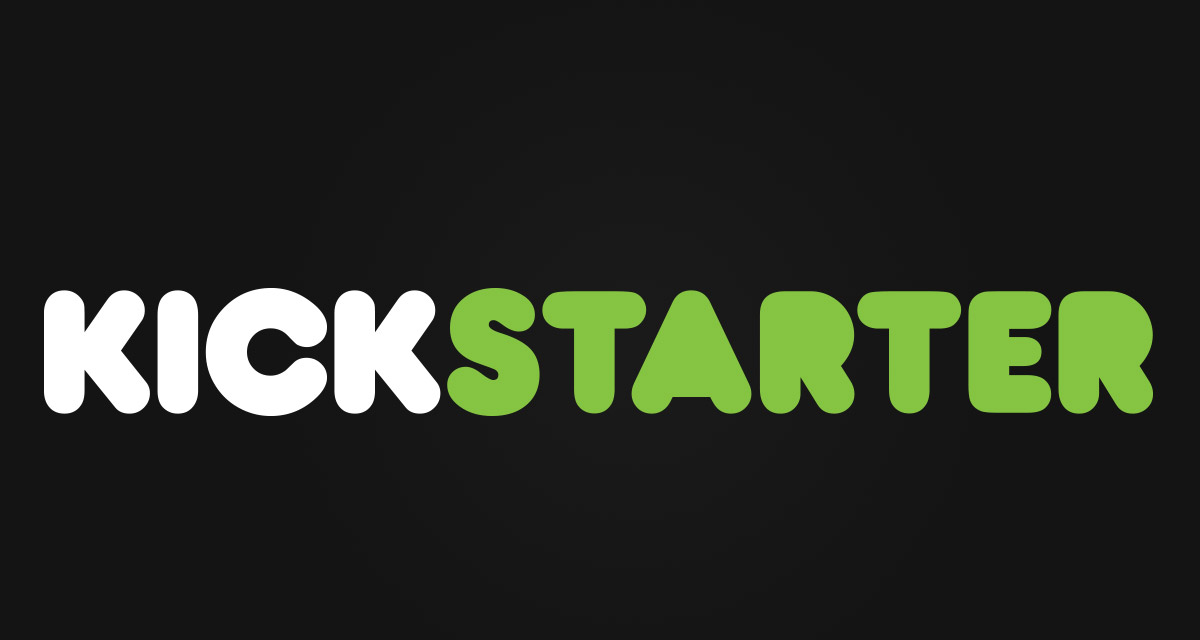

In [8]:
from IPython.display import Image
import pandas as pd
import numpy as np

Image(filename='kickstarter.jpg')

In [9]:
data = pd.read_csv('ks.csv')

In [10]:
data.head()

,Название,Категория,Главная категория,Валюта,Дедлайн,Дата публикации,Состояние,Инвесторов,Страна,Собрано в долларах,Цель в долларах
0,"Don't Call it a Comeback ""Telescopes""",Music,Music,USD,2013-01-10,2012-12-09 06:03:52,successful,23,US,600.00,600.00
1,Arcade County (Canceled),Games,Games,USD,2012-04-29,2012-03-30 23:40:45,canceled,5,US,71.00,9000.00
2,Hayashi Skate Co. Solar Skateboard backpack,Accessories,Fashion,CAD,2017-07-22,2017-05-23 23:00:13,canceled,8,CA,360.36,2391.77
3,Me & You Coordinating Sunglasses- Optical Qual...,Accessories,Fashion,USD,2016-11-18,2016-10-19 22:06:41,failed,20,US,502.00,10000.00
4,New Carts for Istanbul Street Food Vendors,Food,Food,USD,2015-05-17,2015-04-17 18:10:47,successful,62,US,2414.00,1400.00


In [11]:
data.shape

(378661, 11)

In [13]:
### Оставим только нужные состояния

data = data[data['Состояние'].isin(['failed', 'successful'])]

### Что берем за таргет? 2 варианта:

- Будем решать задачу классификации, разметив объекты следующим образом: те проекты, у которых успешный статус, единичкой, а остальные ноликами

- Можем предсказывать просто собранное количество денег, применять модель, а потом уже смотреть, нужная ли сумма получилось. Тогда мы решаем задачу регрессии.

In [18]:
### Создадим колонку таргет1 (бинарный таргет)

data.loc[(data['Состояние'] == 'failed'), 'таргет1'] = 0
data['таргет1'] = data['таргет1'].fillna(1)

In [20]:
data = data.drop('Состояние', axis=1)

In [26]:
### Создадим вещественную колонку таргет2
data = data.rename({'Собрано в долларах':'таргет2'}, axis=1)
data.head()

,Название,Категория,Главная категория,Валюта,Дедлайн,Дата публикации,Инвесторов,Страна,таргет2,Цель в долларах,таргет1
0,"Don't Call it a Comeback ""Telescopes""",Music,Music,USD,2013-01-10,2012-12-09 06:03:52,23,US,600.00,600.0,1.0
3,Me & You Coordinating Sunglasses- Optical Qual...,Accessories,Fashion,USD,2016-11-18,2016-10-19 22:06:41,20,US,502.00,10000.0,0.0
4,New Carts for Istanbul Street Food Vendors,Food,Food,USD,2015-05-17,2015-04-17 18:10:47,62,US,2414.00,1400.0,1.0
5,New Improv Comedy Venue in Des Moines,Theater,Theater,USD,2013-06-17,2013-05-03 16:17:21,86,US,10030.88,10000.0,1.0
6,The Seer and the Sword,Shorts,Film & Video,USD,2012-08-11,2012-07-12 05:19:53,0,US,0.00,10000.0,0.0


### Чтобы получить матрицу объектов, зачастую нужно обработать сырые данные, то есть извлечь из имеющихся таблиц признаки там, где они не даны явно

In [28]:
### Оставим от колонок с датами разницу в днях 

data['Дедлайн'] = pd.to_datetime(data['Дедлайн'])
data['Дата публикации'] = pd.to_datetime(data['Дата публикации'])

In [31]:
data['Срок'] = (data['Дедлайн'] - data['Дата публикации']).dt.days

In [33]:
### Выделим год запуска проекта
data['Год публикации'] = data['Дата публикации'].dt.year

In [34]:
data.head()

,Название,Категория,Главная категория,Валюта,Дедлайн,Дата публикации,Инвесторов,Страна,таргет2,Цель в долларах,таргет1,Срок,Год публикации
0,"Don't Call it a Comeback ""Telescopes""",Music,Music,USD,2013-01-10,2012-12-09 06:03:52,23,US,600.00,600.0,1.0,31,2012
3,Me & You Coordinating Sunglasses- Optical Qual...,Accessories,Fashion,USD,2016-11-18,2016-10-19 22:06:41,20,US,502.00,10000.0,0.0,29,2016
4,New Carts for Istanbul Street Food Vendors,Food,Food,USD,2015-05-17,2015-04-17 18:10:47,62,US,2414.00,1400.0,1.0,29,2015
5,New Improv Comedy Venue in Des Moines,Theater,Theater,USD,2013-06-17,2013-05-03 16:17:21,86,US,10030.88,10000.0,1.0,44,2013
6,The Seer and the Sword,Shorts,Film & Video,USD,2012-08-11,2012-07-12 05:19:53,0,US,0.00,10000.0,0.0,29,2012


### Иногда может казаться, что признаков мало. Стоит подумать над тем, что еще может объяснять таргет-переменную.

In [35]:
Macro = pd.read_excel("macrofeatures.xlsx", engine="openpyxl")

Macro.head()

,Unnamed: 0,Close_brent,Close_sugar,Close_cereals,Close_index_moex,Close_index_moex_10,Close_index_RGBI,Close_index_RTS_oil_and_gas,Close_index_RTS_metallurgy,Close_index_RTS_consumer_sector,Close_index_RTS_telecom,Close_index_RTS_finance,Close_index_RTS_transport,Close_index_RTS_chemicals,Close_index_RTS_broad_market,Close_index_RTS_electricity,dlk_cob_date
0,0,34.41,13.97,442.75,1797.27,3940.81,125.59,123.40,111.97,196.55,70.17,140.57,27.06,177.38,530.59,32.49,2016-02-24
1,1,35.06,14.24,445.25,1803.89,3977.35,126.44,124.22,112.51,198.03,70.56,142.64,27.43,179.48,536.20,33.07,2016-02-25
2,2,35.13,14.00,443.25,1816.73,4027.23,126.90,125.38,113.44,200.13,71.94,145.45,28.06,181.56,544.73,33.55,2016-02-26
3,3,36.64,14.36,445.00,1840.17,4084.24,126.87,126.69,114.66,200.32,72.41,147.22,28.49,186.76,552.82,34.41,2016-02-29
4,4,36.60,14.39,438.50,1844.17,4087.06,127.78,129.72,117.09,204.30,74.26,150.04,30.12,190.67,565.45,34.96,2016-03-01


In [37]:
### Смерджим колонки. Оставим от макрофичей какую-нибудь одну.

Macro = Macro[['Close_brent', 'dlk_cob_date']].drop_duplicates()

In [41]:
Macro['dlk_cob_date'] = pd.to_datetime(Macro['dlk_cob_date'])

In [46]:
data['Дата публикации'] = data['Дата публикации'].dt.date.astype('datetime64[ns]')

In [49]:
data = pd.merge(data,
         Macro,
         left_on=['Дата публикации'],
         right_on=['dlk_cob_date'],
         how='left')

In [50]:
data = data.sort_values('Дата публикации')

In [54]:
data['Close_brent'] = data['Close_brent'].fillna(34.41)

In [56]:
data = data.drop(['Дедлайн', 'Дата публикации', 'dlk_cob_date'], axis=1)

In [57]:
data.head()

,Название,Категория,Главная категория,Валюта,Инвесторов,Страна,таргет2,Цель в долларах,таргет1,Срок,Год публикации,Close_brent
176128,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,30,US,625.0,1000.0,0.0,39,2009,34.41
241929,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,USD,3,US,22.0,80000.0,0.0,87,2009,34.41
244460,drawing for dollars,Illustration,Art,USD,3,US,35.0,20.0,1.0,8,2009,34.41
80845,Offline Wikipedia iPhone app,Software,Technology,USD,25,US,145.0,99.0,1.0,79,2009,34.41
181197,Pantshirts,Fashion,Fashion,USD,10,US,387.0,1900.0,0.0,28,2009,34.41


### Финально, стоит избавиться от колонок, которые мы не считаем признаками

In [58]:
### Уберем колонки Дедлайн, Дата запуска, Инвесторы, Название, Страна

data = data.drop(['Название', 'Страна', 'Инвесторов'], axis=1)

In [59]:
data.head()

,Категория,Главная категория,Валюта,таргет2,Цель в долларах,таргет1,Срок,Год публикации,Close_brent
176128,Fashion,Fashion,USD,625.0,1000.0,0.0,39,2009,34.41
241929,Shorts,Film & Video,USD,22.0,80000.0,0.0,87,2009,34.41
244460,Illustration,Art,USD,35.0,20.0,1.0,8,2009,34.41
80845,Software,Technology,USD,145.0,99.0,1.0,79,2009,34.41
181197,Fashion,Fashion,USD,387.0,1900.0,0.0,28,2009,34.41


## One-hot encoding

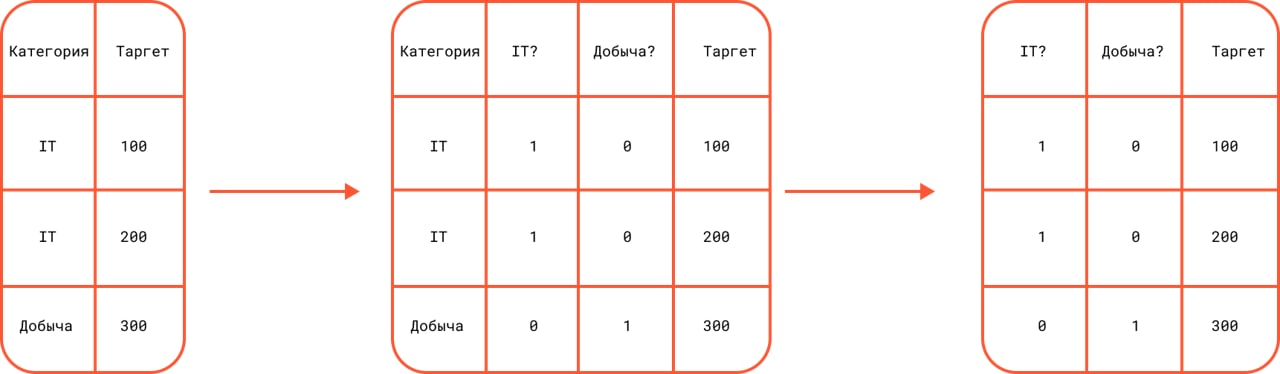

In [63]:
Image('ONEHOT.png')

In [66]:
### One-hot encoding колонки с валютой

data = pd.concat((data, pd.get_dummies(data['Валюта'])), axis=1)
data = data.drop(['Валюта'], axis=1)

In [67]:
data.head()

,Категория,Главная категория,таргет2,Цель в долларах,таргет1,Срок,Год публикации,Close_brent,AUD,CAD,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
176128,Fashion,Fashion,625.0,1000.0,0.0,39,2009,34.41,0,0,...,0,0,0,0,0,0,0,0,0,1
241929,Shorts,Film & Video,22.0,80000.0,0.0,87,2009,34.41,0,0,...,0,0,0,0,0,0,0,0,0,1
244460,Illustration,Art,35.0,20.0,1.0,8,2009,34.41,0,0,...,0,0,0,0,0,0,0,0,0,1
80845,Software,Technology,145.0,99.0,1.0,79,2009,34.41,0,0,...,0,0,0,0,0,0,0,0,0,1
181197,Fashion,Fashion,387.0,1900.0,0.0,28,2009,34.41,0,0,...,0,0,0,0,0,0,0,0,0,1


In [68]:
### Почистим данные от лишней информации 
data = data.drop('AUD', axis=1)

In [69]:
### Аналогично закодируем Главную категорию
data = pd.concat((data, pd.get_dummies(data['Главная категория'])), axis=1)
data = data.drop(['Главная категория'], axis=1)

In [70]:
data.head()

,Категория,таргет2,Цель в долларах,таргет1,Срок,Год публикации,Close_brent,CAD,CHF,DKK,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
176128,Fashion,625.0,1000.0,0.0,39,2009,34.41,0,0,0,...,1,0,0,0,0,0,0,0,0,0
241929,Shorts,22.0,80000.0,0.0,87,2009,34.41,0,0,0,...,0,1,0,0,0,0,0,0,0,0
244460,Illustration,35.0,20.0,1.0,8,2009,34.41,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80845,Software,145.0,99.0,1.0,79,2009,34.41,0,0,0,...,0,0,0,0,0,0,0,0,1,0
181197,Fashion,387.0,1900.0,0.0,28,2009,34.41,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [71]:
data = data.drop('Games', axis=1)

In [73]:
### А что с колонкой Категория?

len(data['Категория'].unique())

159

## Mean-target encoding (Счетчики)

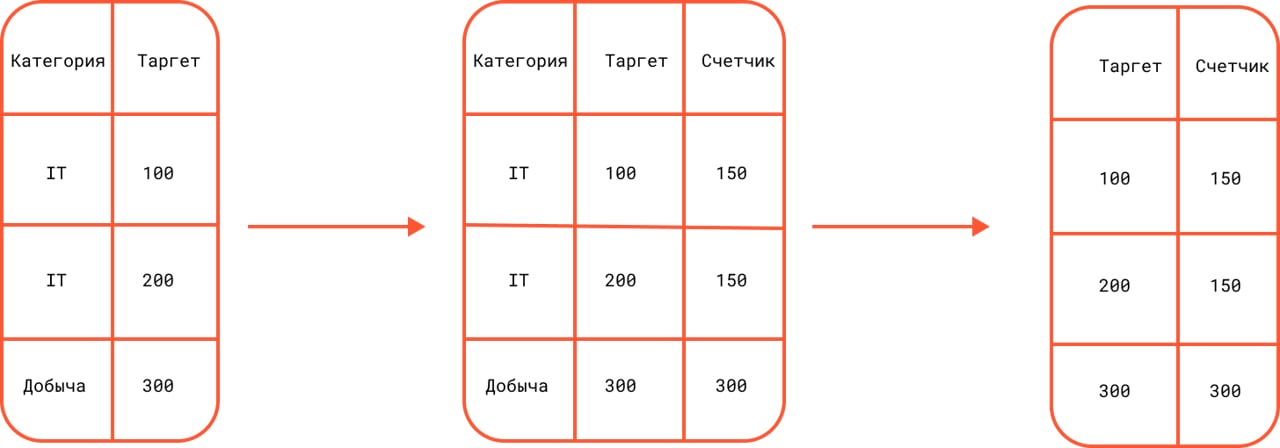

In [62]:
Image('Счетчики.png')

In [75]:
### Произведем mean-target-encoding колонки Категория

data['Категория'] = data['Категория'].map(data.groupby(['Категория'])['таргет2'].mean())

In [76]:
data.head()

,Категория,таргет2,Цель в долларах,таргет1,Срок,Год публикации,Close_brent,CAD,CHF,DKK,...,Design,Fashion,Film & Video,Food,Journalism,Music,Photography,Publishing,Technology,Theater
176128,6035.989239,625.0,1000.0,0.0,39,2009,34.41,0,0,0,...,0,1,0,0,0,0,0,0,0,0
241929,3591.033473,22.0,80000.0,0.0,87,2009,34.41,0,0,0,...,0,0,1,0,0,0,0,0,0,0
244460,3661.424550,35.0,20.0,1.0,8,2009,34.41,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80845,4321.245721,145.0,99.0,1.0,79,2009,34.41,0,0,0,...,0,0,0,0,0,0,0,0,1,0
181197,6035.989239,387.0,1900.0,0.0,28,2009,34.41,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Определимся с таргетом

In [77]:
data = data.drop('таргет1', axis=1)

In [78]:
### Разделим данные на объекты и ответы

X = data.drop('таргет2', axis=1)
Y = data['таргет2']

In [80]:
Y

176128    625.00
241929     22.00
244460     35.00
80845     145.00
181197    387.00
           ...  
247730    269.84
318187    544.77
264474    202.00
293634    265.00
23315     513.60
Name: таргет2, Length: 331675, dtype: float64

### sklearn

In [90]:
### Сейчас будет магия!
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, Y)

X['Предсказание'] = model.predict(X)

X.head()

,Категория,Цель в долларах,Срок,Год публикации,Close_brent,CAD,CHF,DKK,EUR,GBP,...,Fashion,Film & Video,Food,Journalism,Music,Photography,Publishing,Technology,Theater,Предсказание
176128,6035.989239,1000.0,39,2009,34.41,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3462.151236
241929,3591.033473,80000.0,87,2009,34.41,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5388.839779
244460,3661.424550,20.0,8,2009,34.41,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1332.724207
80845,4321.245721,99.0,79,2009,34.41,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5271.256319
181197,6035.989239,1900.0,28,2009,34.41,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2529.810713


In [91]:
data.head()

,Категория,таргет2,Цель в долларах,Срок,Год публикации,Close_brent,CAD,CHF,DKK,EUR,...,Fashion,Film & Video,Food,Journalism,Music,Photography,Publishing,Technology,Theater,prediction
176128,6035.989239,625.0,1000.0,39,2009,34.41,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3462.151236
241929,3591.033473,22.0,80000.0,87,2009,34.41,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5388.839779
244460,3661.424550,35.0,20.0,8,2009,34.41,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1332.724207
80845,4321.245721,145.0,99.0,79,2009,34.41,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5271.256319
181197,6035.989239,387.0,1900.0,28,2009,34.41,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2529.810713


In [50]:
#Запишем результат в data.csv
